# Cas protein and spacer cassette analysis 
### Relating expression to spacer cassette size (hopefully)

Plan:
1. Filter Cas protein results in database to only those that are near a CRISPR casette, and/or filter only high e-value hits or certain protein types. 
2. Get neighbouring casette lengths (copy code from locus number of spacers analysis)
3. Get DNA for *cas* genes and get codons, run through a codon usage analyzer

Will need to download genomes as well.

### To-do
- [x] Check git log on school Lenovo, get details of database creation (number of genomes analyzed, CRISPRfinder parameters, etc)


In [1]:
%matplotlib inline

In [2]:
import requests
import json
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib import mlab
import seaborn as sns
import pandas as pd
from scipy import stats
from tqdm import tqdm
from Bio import SeqIO

sns.set_palette("husl")

In [3]:
#Url of the phageParser API
apiurl = 'https://phageparser.herokuapp.com'
#Get the initial page for listing of accessible objects and get url for organisms and casproteins
url_json=requests.get(apiurl).json()
organisms_url = url_json['organisms']
cas_proteins_url = url_json['casproteins']
organism_cas_url = url_json['organismcas']
loci_url = url_json['loci']

In [4]:
#Iterate through each page and merge the json response into a dictionary for cas proteins
cas_protein_dict = {}
r=requests.get(cas_proteins_url)
last_page = r.json()['meta']['total_pages']
for page in tqdm(range(1,last_page+1)):
    url = cas_proteins_url+'?page={}'.format(page)
    payload = requests.get(url).json()
    cas_protein_objs = payload['cas_proteins']
    for cas_protein_obj in cas_protein_objs:
        cas_protein_dict[cas_protein_obj['id']] = cas_protein_obj

100%|██████████| 1/1 [00:01<00:00,  1.71s/it]


In [5]:
#Iterate through each page and merge the json response into a dictionary for organisms
organism_dict = {}
r=requests.get(organisms_url)
last_page = r.json()['meta']['total_pages']
for page in tqdm(range(1,last_page+1)):
    url = organisms_url+'?page={}&include[]=cas_proteins&include[]=loci.spacers'.format(page)
    payload = requests.get(url).json()
    organism_objs = payload['organisms']
    for organism_obj in organism_objs:
        organism_dict[organism_obj['id']] = organism_obj

100%|██████████| 7/7 [01:58<00:00, 17.06s/it]


In [6]:
# Iterate through each page and merge the json response into a dictionary for organism_cas
# this takes a long time
organism_cas_dict = {}
r = requests.get(organism_cas_url)
last_page = r.json()['meta']['total_pages']
for page in tqdm(range(1, last_page+1)):
    url = organism_cas_url+'?page={}'.format(page)
    payload = requests.get(url).json()
    organism_cas_objs = payload['organism_cas_proteins']
    for organism_cas_obj in organism_cas_objs:
        organism_cas_dict[organism_cas_obj['id']] = organism_cas_obj

100%|██████████| 446/446 [08:39<00:00,  1.03s/it]


In [7]:
# Iterate through each page and merge the json response into a dictionary for loci
loci_dict = {}
r = requests.get(loci_url)
last_page = r.json()['meta']['total_pages']
for page in tqdm(range(1, last_page+1)):
    url = loci_url+'?page={}&include[]=spacers'.format(page)
    payload = requests.get(url).json()
    loci_objs = payload['locus']
    for locus_obj in loci_objs:
        loci_dict[locus_obj['id']] = locus_obj

100%|██████████| 18/18 [01:37<00:00,  4.62s/it]


In [8]:
# create dictionary with the info and positions of all cas proteins in each organism
# note: this may be longer than the list of cas proteins in the organism dict, since some proteins may appear twice
from collections import defaultdict

organism_to_cas_dict = defaultdict(dict)
for i, values in organism_cas_dict.items():
    organism_to_cas_dict[values['organism']][i] = values

### Retain only cas proteins near a cassette

In [9]:
distance_from_locus = 50000 # base pairs, look up what would be a good value
# a cas9 sequence that I randomly found is like 9000 bp, so 50 000 seems like a reasonable cutoff.
# also the cutoff doesn't really matter - the numbers are the same whether the cutoff is 50 000 or 500 000

In [10]:
organism_names = []
loci = []
cas_genes = []
organism_names_all = []
cas_near_cassette_dict = defaultdict(dict)

for organism_id in organism_dict.keys():

    # search_window[0] must be less than search_window[1]

    search_windows = {}
    for locus in organism_dict[organism_id]['loci']:
        # check that start is less than end
        if not locus['genomic_start'] < locus['genomic_end']:
            print('end is less than start')
        search_windows[locus['id']] = {'window': [locus['genomic_start'] - 1000, locus['genomic_end'] + 1000]}
    
    for locus_id, windows in search_windows.items():
        for cas_id, values in organism_to_cas_dict[organism_id].items():
            #print(values['genomic_start'])
            if values['genomic_start'] > windows['window'][0] and values['genomic_end'] < windows['window'][1]:
                #print(organism_id, organism_dict[organism_id]['accession'], organism_dict[organism_id]['name'], locus_id)
                organism_names.append("%s %s\n" %(organism_dict[organism_id]['accession'], organism_dict[organism_id]['name']))
                loci.append(locus_id)
                cas_genes.append(values['casprotein'])
                cas_near_cassette_dict[organism_id][cas_id] = values
                cas_near_cassette_dict[organism_id][cas_id]['locus'] = locus_id # also add locus id
                
    organism_names_all.append("%s %s\n" %(organism_dict[organism_id]['accession'], organism_dict[organism_id]['name']))
                

In [11]:
# create dictionary linking accession numbers and organism IDs
accession_to_organism_id = {}
for key, values in organism_dict.items():
    accession_to_organism_id[values['accession']] = key

In [12]:
print(len(set(organism_names)))
print(len(set(loci)))
print(len(set(cas_genes)))
print(len(cas_genes))
print(len(cas_protein_dict))

473
590
202
731
394


In [13]:
# save list of organisms that have cas proteins near casettes
organism_names = list(set(organism_names))

with open('organism_names.txt', 'w') as file:
    for line in organism_names:
        file.write(line)
        
organism_names_all = list(set(organism_names_all))

with open('organism_names_all.txt', 'w') as file:
    for line in organism_names_all:
        file.write(line)
        

In [14]:
# create accession list
!cat organism_names.txt | cut -d" " -f1 > organism_accessions.txt

!cat organism_names_all.txt | cut -d" " -f1 > organism_accessions_all.txt

# download all organism genomes that were found to be hits
#!cat organism_accessions.txt | python ../parserscripts/acc2gb.py your@email.com nuccore fasta_cds_na > cas_bacteria.dat

Need CDS regions for the AnaCoDa thing, so to download CDS fasta I think use `fasta_cds_na` (nucleotides for cds) or `fasta_cds_aa` (translated amino acids for cds). 

In [ ]:
# split fasta file for all organisms into files separated by organism - only run once

current_accession = 0
past_accession = 0

for record in tqdm(SeqIO.parse("cas_bacteria.dat", "fasta")):
    header = record.id
    accession = header.rsplit('|')[1].rsplit('.')[0]
    current_accession = accession
    if current_accession != past_accession: # start a new file
        with open("%s.fasta" %accession, "w") as output_handle:
            SeqIO.write(record, output_handle, "fasta")
    else:
        with open("%s.fasta" %accession, "a") as output_handle:
            SeqIO.write(record, output_handle, "fasta")
    past_accession = current_accession

In [17]:
folder = "/media/madeleine/My\ Passport1/Data/AnaCoDa"
folder_python = "/media/madeleine/My Passport1/Data/AnaCoDa"

In [18]:
# link cas genes to their position in the cds list
for record in tqdm(SeqIO.parse("cas_bacteria.dat", "fasta")):
    header = record.id
    accession = header.rsplit('|')[1].rsplit('.')[0]
    org_id = accession_to_organism_id[accession]
    cds_number = int(header.split('_')[-1])
    description = record.description
    
    for key, value in cas_near_cassette_dict[org_id].items():
        try: 
            start = description.index(str(value['genomic_start'])) # this fails if this isn't the cas gene
            end = description.index(str(value['genomic_end']))
            cas_near_cassette_dict[org_id][key]['cds_number'] = cds_number
            #print(org_id)
        except:
            pass

1200252it [00:30, 38807.81it/s]


## Analysis plan

1. Get expression model data using the [AnaCoDa R package](https://rdrr.io/cran/AnaCoDa/f/inst/doc/anacoda.Rmd), save file as `accession-expression.csv`
2. Load expression data using pandas
3. Get cas gene ids: 
```
cas_gene_positions = []
for val in cas_near_cassette_dict[accession_to_organism_id['NZ_CP015184']].values():
    cas_gene_positions.append(val['cds_number'])
```
4. The gene ids-1 are the index for the expression data frame (b/c zero indexing) **expression levels**
5. Get associated locus size: 
```
associated_loci = []
loci_lengths = []
for val in cas_near_cassette_dict[accession_to_organism_id['NZ_CP015184']].values():
    associated_loci.append(val['locus'])
    loci_lengths.append(len(loci_dict[val['locus']]['spacers'])
```
6. Multiple genes may be associated with the same locus, but now `cas_gene_positions` and `associated_loci` should be the same length to match them up (locus indices may be repeated). **locus lengths**

Annddd.... done! Make a sweet plot

One issue to think about: some cas genes might be counted twice as being near two loci, if the loci are very close together. Is this an issue?

Removed genome NZ_CP009177 from organism accession list - causing errors

In [19]:
folder = "expression"

In [20]:
# get list of which organisms have been analyzed
!ls $folder/*expression.csv | cut -d"-" -f1 | rev | cut -d"/" -f1 | rev > done_accessions.txt 

In [21]:
accessions = pd.read_csv("organism_accessions.txt", names = ['acc']) # ones with cas near CRISPR array by our analysis

In [22]:
accessions_done = pd.read_csv("done_accessions.txt", names = ['acc'])

expression_all_list = []
expression_list = []
locus_size_list = []
for accession in tqdm(accessions.acc):
    if accession not in list(accessions_done.acc):
        continue

    expression = pd.read_csv("%s/%s-expression.csv" %(folder, accession))
    #print(np.mean(expression.PHI))
    # split names column from the right to isolate cds position
    names_split = expression["names"].str.rsplit("_", n=1, expand = True)  
    expression["protein_position"] = names_split.iloc[:,-1] # create column for cds position
    expression["protein_position"] = pd.to_numeric(expression["protein_position"]) # convert to numeric
    
    expression_all_list.append(expression)
    
    cas_gene_positions = []
    skip_keys = []
    for key, val in cas_near_cassette_dict[accession_to_organism_id[accession]].items():
        try:
            cas_gene_positions.append(val['cds_number'])
        except:
            print("no cds position", str(accession_to_organism_id[accession]), str(key))
            skip_keys.append(key)
    
    if cas_gene_positions == []: # if it's an empty list
        continue
        
    associated_loci = []
    loci_lengths = []
    for key, val in cas_near_cassette_dict[accession_to_organism_id[accession]].items():
        if key in skip_keys:
            continue
        associated_loci.append(val['locus'])
        loci_lengths.append(len(loci_dict[val['locus']]['spacers']))
        
    # get expression level for the cas genes in the organism (normalize by mean expression level)
    expression_vals = expression.loc[expression["protein_position"].isin(cas_gene_positions)].PHI / np.mean(expression.PHI)
    if expression_vals.empty:
        print(expression_vals)
        expression_vals_empty = expression
        cas_gene_positions_empty = cas_gene_positions
    
    #print(np.array(expression_vals), loci_lengths, associated_loci, accession)
    expression_list.append(list(expression_vals))
    locus_size_list.append(loci_lengths)
    

 40%|████      | 191/473 [00:04<00:06, 41.93it/s]

no cds position 2932 135754
no cds position 1990 151219


 71%|███████   | 337/473 [00:08<00:02, 46.43it/s]

no cds position 359 222463


 78%|███████▊  | 371/473 [00:09<00:02, 46.35it/s]

no cds position 2275 147874


 91%|█████████ | 431/473 [00:10<00:00, 49.44it/s]

no cds position 2965 86582
no cds position 2268 220471


 93%|█████████▎| 442/473 [00:10<00:00, 47.61it/s]

no cds position 2299 12543


100%|██████████| 473/473 [00:11<00:00, 41.37it/s]


In [23]:
# flatten lists

expression_list_flat = [item for sublist in expression_list for item in sublist] 
locus_size_list_flat = [item for sublist in locus_size_list for item in sublist] 

sort_inds = np.argsort(locus_size_list_flat)
locus_size_list_flat = np.array(locus_size_list_flat)[sort_inds]
expression_list_flat = np.array(expression_list_flat)[sort_inds]

from scipy.optimize import curve_fit

def line(x, A, B): # this is your 'straight line' y=f(x)
    return A*x + B

A,B = curve_fit(line, locus_size_list_flat, expression_list_flat)[0] # your data x, y to fit

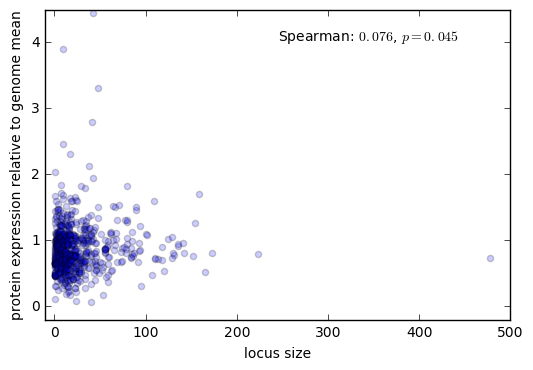

In [24]:
fig, ax = plt.subplots()
#ax.set_xscale('log')
ax.scatter(locus_size_list_flat, expression_list_flat, alpha = 0.2)
#ax.plot(locus_size_list_flat, np.array(locus_size_list_flat)*A+B)
ax.set_xlabel("locus size")
ax.set_ylabel("protein expression relative to genome mean")
spearman = stats.spearmanr(expression_list_flat, locus_size_list_flat)
ax.annotate(r"Spearman: $%s$, $p=%s$" %(round(spearman[0],3), round(spearman[1],3)), 
                 xy = (0.5, 0.9), xycoords = 'axes fraction')
ax.set_ylim(-0.2,4.5)
ax.set_xlim(-10, 500)
plt.savefig("cas_expression_vs_locus_size.png", dpi = 200)

In [ ]:
A,B = curve_fit(line, expression_list_flat, locus_size_list_flat)[0] # your data x, y to fit

In [ ]:
curve_fit(line, expression_list_flat, locus_size_list_flat)[1]

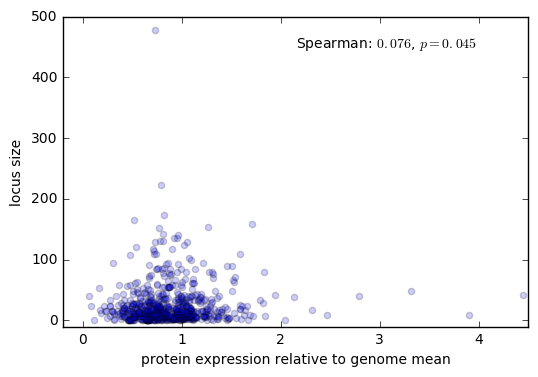

In [25]:
fig, ax = plt.subplots()
#ax.set_xscale('log')
ax.scatter(expression_list_flat, locus_size_list_flat,  alpha = 0.2)
#ax.plot(expression_list_flat, np.array(expression_list_flat)*A+B)
ax.set_ylabel("locus size")
ax.set_xlabel("protein expression relative to genome mean")
spearman = stats.spearmanr(expression_list_flat, locus_size_list_flat)
ax.annotate(r"Spearman: $%s$, $p=%s$" %(round(spearman[0],3), round(spearman[1],3)), 
                 xy = (0.5, 0.9), xycoords = 'axes fraction')
ax.set_xlim(-0.2,4.5)
ax.set_ylim(-10, 500)
plt.savefig("locus_size_vs_cas_expression.png", dpi = 200)


In [27]:
stats.spearmanr(expression_list_flat, locus_size_list_flat)

SpearmanrResult(correlation=0.075944382016777681, pvalue=0.045039467279392585)

In [26]:
stats.pearsonr(expression_list_flat, locus_size_list_flat)

(0.053130351571048069, 0.16116813910108529)

From their paper, "the units of phi are proteins per time, and time is scaled such that the the prior for phi satisfies E(phi) = 1." I don't really know what that means, but it hopefully means that results are comparable across genomes?

In [ ]:
fig, ax = plt.subplots(2,3, figsize = (12,8))

axs = ax.flatten()

for i in range(6):
    axs[i].hist(expression_all_list[i*10].PHI, bins = 20)

    axs[i].set_ylabel("Number of genes")
    print(accessions_done.loc[i*10])
    axs[i].set_title(accessions_done.loc[i*10,'acc'])
axs[4].set_xlabel("Expression (proteins / time)")
plt.tight_layout()
plt.savefig("expression_samples.png", dpi = 200)

In [ ]:
organism_id = 25

search_windows = {}
for locus in organism_dict[organism_id]['loci']:
    # check that start is less than end
    if not locus['genomic_start'] < locus['genomic_end']:
        print('end is less than start')
    search_windows[locus['id']] = {'window': [locus['genomic_start'] - 1000, locus['genomic_end'] + 1000]}



In [ ]:
plot_regions = []
for loci in organism_dict[organism_id]['loci']:
    #print(loci['genomic_start'], loci['genomic_end'])
    plot_regions.append({'position': [loci['genomic_start'], loci['genomic_end']], 'label': 'casette'})
    
for locus_id, windows in search_windows.items():
    for cas_id, values in organism_to_cas_dict[organism_id].items():
        #print(values['genomic_start'])
        if values['genomic_start'] > windows['window'][0] and values['genomic_end'] < windows['window'][1]:
            #print(str(organism_id) + 'yes')
            plot_regions.append({'position': [values['genomic_start'], values['genomic_end']], 
                                 'label': cas_protein_dict[values['casprotein']]['gene']})
            print(values)
    

In [ ]:
plot_regions

In the NCBI database for this organism, the closest CDS regions for the cas genes are:

```
complement(108876..109115)
                     /locus_tag="GZL_RS47195"
                     /inference="COORDINATES: similar to AA
                     sequence:RefSeq:WP_006272258.1"
                     /note="Derived by automated computational analysis using
                     gene prediction method: Protein Homology."
                     /codon_start=1
                     /transl_table=11
                     /product="hypothetical protein"
                     /protein_id="WP_078876378.1"
                     /translation="MVLDPFGGTGTTAAAAKVLGRVGISVDLSPAYTRTAASPSPTPS
                     ANGVARPAGEWGSSSPQSSNWSTLWWMARLRLTLS"
```

```
109222..109647
                     /locus_tag="GZL_RS43525"
                     /old_locus_tag="GZL_p00118"
                     /inference="COORDINATES: ab initio prediction:GeneMarkS+"
                     /note="Derived by automated computational analysis using
                     gene prediction method: GeneMarkS+."
                     /codon_start=1
                     /transl_table=11
                     /product="hypothetical protein"
                     /protein_id="WP_040108171.1"
                     /translation="MHRDVTARPWAREREQARAWQAVVAARAEAAAARPEENVDVSVV
                     APAPVVLPAPRPSAAATEPELEDADDDQDLVLEDLTREQVLGWRDRAATDHQIVHDHI
                     ARYGEHSAQRLFTRAFVATVQRLSHLGHLDLGYTPWRQA"
```

So the good news is, the windows that the database outputs correspond to true CDS regions in NCBI, and we can get the translation from NCBI if necessary. Perhaps we should download the genbank files? or will it work to translate them ourselves?

In [ ]:
fig, ax = plt.subplots(figsize = (20,2))

# get max range needed
min_value = 10**10
max_value = 0
for region in plot_regions:
    if region['position'][0] < min_value:
        min_value = region['position'][0]
    if region['position'][1] > max_value:
        max_value = region['position'][1]
     
    #if region['label'] == 'casette':
    #    colour = 'b'
    #else:
    #    colour = 'g'
    if region['label'] == 'casette':
        ax.fill_between([region['position'][0], region['position'][1]],0,1, color = 'b')
    else:
        ax.fill_between([region['position'][0], region['position'][1]],0,1, label = region['label'])

#ax.set_xlim(1893000, 1910000)
#ax.set_xlim(748000, 753000)
ax.legend(loc='best')
    

In [ ]:
# download a bacterial genome

accession = organism_dict[organism_id]['accession']
print(accession)
print(organism_dict[organism_id]['name'])
!echo "$accession" | python ../parserscripts/acc2gb.py madeleine.bonsma@gmail.com nuccore fasta > "$accession".dat

In [ ]:
from Bio import SeqIO
for record in SeqIO.parse("%s.dat" %accession, "fasta"):
    genome = record.seq

In [ ]:
from Bio import Seq
print(Seq.transcribe(Seq.reverse_complement(genome[109222:109647])))
print(Seq.translate((genome[109222:109647])))

In [ ]:
len(genome[109222:109647])/3

In [ ]:
print(genome[109222:109647])

# Another option
Makarova et al. (2015) also have a table that lists every singe locus and all the gene positions. Let's just use that in combination with the locus data - that's many more data points! 

From the 2015 paper: they use 530 bp as the cutoff for distance between CRISPR array and cas genes. 

In [28]:
makarova_data = pd.read_csv("nrmicro3569-s7_cleaned.csv")

In [29]:
makarova_data.head()

,#Locus ID / GI,(sub)Type / Coordinates,Strand,Genome,Genome partition ID,Gene number on the genome partition,Cas profile ID (CDD ID for non-cas proteins),Cas core,Cas gene
0,# 384117643,CAS-I-E,NaN,Acetobacter_pasteurianus_IFO_3283_01_42C_uid15...,NC_017104,NaN,NaN,NaN,NaN
1,384117643,114611..117325,+,Acetobacter_pasteurianus_IFO_3283_01_42C_uid15...,NC_017104,103.0,COG1203,+,cas3
2,384117644,117387..119042,+,Acetobacter_pasteurianus_IFO_3283_01_42C_uid15...,NC_017104,104.0,cd09729,+,cas8e
3,384117645,119042..119602,+,Acetobacter_pasteurianus_IFO_3283_01_42C_uid15...,NC_017104,105.0,cd09731,+,cse2gr11
4,384117646,119623..120681,+,Acetobacter_pasteurianus_IFO_3283_01_42C_uid15...,NC_017104,106.0,pfam09344,+,cas7


In [30]:
makarova_data.columns

Index(['#Locus ID / GI', '(sub)Type / Coordinates', 'Strand', 'Genome',
       'Genome partition ID', 'Gene number on the genome partition',
       'Cas profile ID (CDD ID for non-cas proteins)', 'Cas core', 'Cas gene'],
      dtype='object')

The locus type and titles are mixed in with columns - will be tricky to sort it out. Each new locus has a hash symbol in the '#Locus ID / GI' column.

In [31]:
makarova_data[["#Locus ID / GI", '(sub)Type / Coordinates']].head()

,#Locus ID / GI,(sub)Type / Coordinates
0,# 384117643,CAS-I-E
1,384117643,114611..117325
2,384117644,117387..119042
3,384117645,119042..119602
4,384117646,119623..120681


In [32]:
# get 'True' wherever a locus starts, get the index of all True
repeats1 = np.arange(len(makarova_data))[np.array(makarova_data["#Locus ID / GI"].str.contains('#'))]

# add the length of the data to count the last locus
repeats1 = np.append(repeats1, len(makarova_data)) 

In [33]:
# array giving the length of each locus (# of times label should be repeated)
repeats = repeats1[1:] - repeats1[:-1]
locus_id = np.arange(len(repeats)) # give a unique ID to each locus

In [34]:
locus_id_column = np.repeat(locus_id, repeats)
crispr_types = makarova_data.loc[makarova_data["#Locus ID / GI"].str.contains('#'), "(sub)Type / Coordinates"]
type_column = np.array(np.repeat(crispr_types, repeats))

In [35]:
# assign new columns
makarova_data["locus_id"] = locus_id_column
makarova_data["CRISPR_type"] = type_column

In [36]:
makarova_data.tail(n=20)

,#Locus ID / GI,(sub)Type / Coordinates,Strand,Genome,Genome partition ID,Gene number on the genome partition,Cas profile ID (CDD ID for non-cas proteins),Cas core,Cas gene,locus_id,CRISPR_type
17283,345004205,199240..200190,-,halophilic_archaeon_DL31_uid72619,NC_015954,195.0,cd09709,+,csc2gr7,1946,CAS-I-D
17284,345004206,200187..202673,-,halophilic_archaeon_DL31_uid72619,NC_015954,196.0,cd09712,+,cas10d,1946,CAS-I-D
17285,345004207,202670..203539,-,halophilic_archaeon_DL31_uid72619,NC_015954,197.0,pfam10040,+,cas6,1946,CAS-I-D
17286,345004208,203689..204333,+,halophilic_archaeon_DL31_uid72619,NC_015954,198.0,cls001593,NaN,casR,1946,CAS-I-D
17287,# 189485058,CAS-II-C,NaN,uncultured_Termite_group_1_bacterium_phylotype...,NC_020419,NaN,NaN,NaN,NaN,1947,CAS-II-C
17288,189485058,101786..102286,+,uncultured_Termite_group_1_bacterium_phylotype...,NC_020419,55.0,cd09643,+,cas9,1947,CAS-II-C
17289,189485059,102302..105400,+,uncultured_Termite_group_1_bacterium_phylotype...,NC_020419,56.0,cd09643,+,cas9,1947,CAS-II-C
17290,189485060,105401..106312,+,uncultured_Termite_group_1_bacterium_phylotype...,NC_020419,57.0,cd09720,+,cas1,1947,CAS-II-C
17291,189485061,106296..106622,+,uncultured_Termite_group_1_bacterium_phylotype...,NC_020419,58.0,mkCas0206,+,cas2,1947,CAS-II-C
17292,# 189485218,CAS-I-C;CAS-II-C,NaN,uncultured_Termite_group_1_bacterium_phylotype...,NC_020419,NaN,NaN,NaN,NaN,1948,CAS-I-C;CAS-II-C


In [37]:
# remove the rows that are the locus titles
makarova_data = makarova_data.loc[~makarova_data['#Locus ID / GI'].str.contains('#')]

In [38]:
# rename some columns
makarova_data = makarova_data.rename(columns = {'#Locus ID / GI': 'gene_id', 'Genome partition ID': 'accession'})

In [39]:
# number of unique organisms
len(pd.unique(makarova_data['accession']))

1263

In [40]:
accessions_all = pd.read_csv("organism_accessions_all.txt", names = ['acc']) # all organisms with CRISPR arrays
accessions = pd.read_csv("organism_accessions.txt", names = ['acc']) # ones with cas near CRISPR array

In [41]:
# get a list of all the organisms that are in either our group or the makarova group
set1 = set(accessions['acc'])
set2 = set(pd.unique(makarova_data['accession'])) # makarova genomes with cas loci
set3 = set(accessions_all['acc'])

union = list(set1.union(set2))

intersection_all = list(set3.intersection(set2))

difference = list(set(intersection_all).difference(set1))

print(len(union))

# this many genomes that are in the makarova data have had their expression analyzed
makarova_done = set2.intersection(set(accessions_done['acc']))
print(len(makarova_done))

1469
1148


Need CDS regions for the AnaCoDa thing, so to download CDS fasta I think use `fasta_cds_na` (nucleotides for cds) or `fasta_cds_aa` (translated amino acids for cds). 

In [42]:
with open("accessions_overlap.txt", "w") as file:
    for acc in intersection_all:
        file.write(acc + "\n")

In [43]:
done_accessions = pd.read_csv("done_accessions.txt", names = ['acc'])

In [44]:
remaining_to_analyze = pd.DataFrame(list(set(intersection_all).difference(set(done_accessions['acc']))), columns = ['acc'])

In [45]:
len(remaining_to_analyze)

15

In [46]:
remaining_to_analyze.to_csv("remaining_to_analyze.txt", index = None, header = None)

In [47]:
#downloaded_genomes = pd.read_csv("downloaded_genomes.txt",  names = ['acc'])

In [48]:
#to_download = list(set(intersection_all).difference(set(downloaded_genomes['acc'])))

In [ ]:
# need to download a few more organisms that aren't in our list

for acc in to_download:
    !echo "$acc" | python ../parserscripts/acc2gb.py your@email.com nuccore fasta_cds_na > "$acc".fasta

In [62]:
makarova_subset = makarova_data[makarova_data['accession'].isin(makarova_done)]

In [50]:
len(makarova_subset)

14433

Split the coordinates into genome start and end columns

In [51]:
makarova_subset.loc[:,["(sub)Type / Coordinates"]] = makarova_subset["(sub)Type / Coordinates"].astype(str)

/home/madeleine/anaconda2/envs/django/lib/python3.5/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [63]:
new_cols = makarova_subset["(sub)Type / Coordinates"].str.split(".", expand = True)

In [64]:
makarova_subset["Genomic start"] = new_cols[0]
makarova_subset["Genomic end"] = new_cols[2]

/home/madeleine/anaconda2/envs/django/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/home/madeleine/anaconda2/envs/django/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [65]:
makarova_subset.head()

,gene_id,(sub)Type / Coordinates,Strand,Genome,accession,Gene number on the genome partition,Cas profile ID (CDD ID for non-cas proteins),Cas core,Cas gene,locus_id,CRISPR_type,Genomic start,Genomic end
1,384117643,114611..117325,+,Acetobacter_pasteurianus_IFO_3283_01_42C_uid15...,NC_017104,103.0,COG1203,+,cas3,0,CAS-I-E,114611,117325
2,384117644,117387..119042,+,Acetobacter_pasteurianus_IFO_3283_01_42C_uid15...,NC_017104,104.0,cd09729,+,cas8e,0,CAS-I-E,117387,119042
3,384117645,119042..119602,+,Acetobacter_pasteurianus_IFO_3283_01_42C_uid15...,NC_017104,105.0,cd09731,+,cse2gr11,0,CAS-I-E,119042,119602
4,384117646,119623..120681,+,Acetobacter_pasteurianus_IFO_3283_01_42C_uid15...,NC_017104,106.0,pfam09344,+,cas7,0,CAS-I-E,119623,120681
5,384117647,120687..121466,+,Acetobacter_pasteurianus_IFO_3283_01_42C_uid15...,NC_017104,107.0,cd09693,+,cas5,0,CAS-I-E,120687,121466


In [66]:
makarova_subset.loc[makarova_subset["Genomic start"] > makarova_subset["Genomic end"]]

,gene_id,(sub)Type / Coordinates,Strand,Genome,accession,Gene number on the genome partition,Cas profile ID (CDD ID for non-cas proteins),Cas core,Cas gene,locus_id,CRISPR_type,Genomic start,Genomic end
142,302347811,7459..10350,-,Acidilobus_saccharovorans_345_15_uid51395,NC_014374,9.0,cls000742,+,cas10,15,CAS-III-B,7459,10350
491,288947675,23..1168,+,Allochromatium_vinosum_DSM_180_uid46083,NC_013852,1.0,cd09742,NaN,csm6,60,CAS-III-B,23,1168
552,260892869,999552..1000265,+,Ammonifex_degensii_KC4_uid41053,NC_013385,939.0,cd09683,+,csm3gr7,67,CAS-I-B;CAS-III,999552,1000265
3214,479136975,8236..12252,+,Coprococcus_catus_GD_7_uid197174,NC_021009,8.0,mkCas0193,+,cas9,359,CAS-II-A,8236,12252
3924,452202937,97899..100319,+,Dehalococcoides_mccartyi_DCMB5_uid190184,NC_020386,92.0,COG1203,+,cas3,449,CAS-I-C,97899,100319
3981,386855144,9628..10290,-,Deinococcus_gobiensis_I_0_uid162509,NC_017806,16.0,cd09756,+,cas5,455,CAS-I-E,9628,10290
4097,328951837,99529..101334,-,Desulfobacca_acetoxidans_DSM_11109_uid65785,NC_015388,91.0,COG1203,+,cas3,467,CAS-I-B,99529,101334
4573,317051106,999836..1000039,+,Desulfurispirillum_indicum_S5_uid45897,NC_014836,907.0,-,NaN,-,522,CAS-I-F,999836,1000039
5005,386594500,999625..1001133,+,Escherichia_coli_DH1_uid161951,NC_017625,910.0,cd09669,+,cas8e,571,CAS-I-E,999625,1001133
5501,518651370,9550..10275,-,Ferroplasma_acidarmanus_fer1_uid54095,NC_021592,9.0,COG1583,+,cas6,629,CAS-I-B,9550,10275


Looks like the genomic start is always less than the genomic end. 

Now get the ones that are near loci!

In [67]:
locus_min_max = (makarova_subset.groupby(["accession","locus_id"])
                 .agg({"Genomic start": np.min,"Genomic end": np.max}))

locus_min_max = locus_min_max.reset_index()
locus_min_max = locus_min_max.set_index('locus_id')
locus_min_max.head()



,accession,Genomic end,Genomic start
locus_id,,,
1813,NC_000853,1791275,1766027
41,NC_000854,786281,776023
1264,NC_000868,984864,978707
936,NC_000909,351645,339917
937,NC_000909,1658533,1648677


In [68]:
cas_locus_to_crispr_array = {}
cutoff = 530
count = 0
for locus in np.unique(makarova_subset["locus_id"]):
    accession = locus_min_max.loc[locus]['accession']
    org_id = accession_to_organism_id[accession]
    cas_locus_start = int(locus_min_max.loc[locus]['Genomic start'])
    cas_locus_end = int(locus_min_max.loc[locus]['Genomic end'])
    
    for loc in organism_dict[org_id]['loci']:
        crispr_array_start = loc['genomic_start']
        crispr_array_end = loc['genomic_end']
        
        if np.abs(crispr_array_start - cas_locus_end) < cutoff or np.abs(crispr_array_end - cas_locus_start) < cutoff:
            count += 1
            try:
                cas_locus_to_crispr_array[locus].append({"locus_id": loc['id'], "crispr_length": len(loc['spacers'])})
            except:
                cas_locus_to_crispr_array[locus] = [{"locus_id": loc['id'], "crispr_length": len(loc['spacers'])}]

### What do do with cas genes near multiple loci?

In [69]:
# an example with two nearby loci
print(cas_locus_to_crispr_array[20])

array1 = [loci_dict[3162]['genomic_start'], loci_dict[3162]['genomic_end']]
array2 = [loci_dict[7212]['genomic_start'], loci_dict[7212]['genomic_end']]
locus1 = [int(locus_min_max.loc[20]['Genomic start']), int(locus_min_max.loc[20]['Genomic end'])]

accession = organism_dict[loci_dict[3162]['organism']]['accession']

[{'locus_id': 3162, 'crispr_length': 4}, {'locus_id': 7212, 'crispr_length': 7}]


In [74]:
gene_positions = makarova_subset.loc[makarova_subset['accession'] == 
                                     locus_min_max.loc[20]['accession']][['Genomic start', 
                                                                          'Genomic end']]

In [79]:
for i in np.array(gene_positions):
    print(i[0])

935088
937392
938138
939196
939901
939999


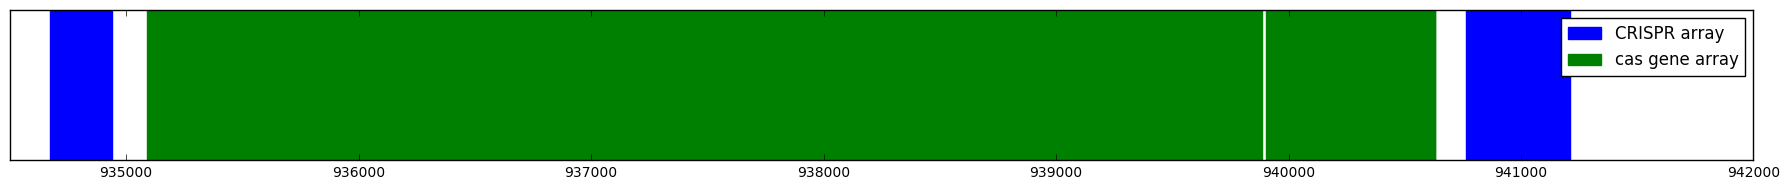

In [82]:
fig, ax = plt.subplots(figsize = (18,2))

ax.fill_between([array1[0], array1[1]],0,1, color = 'b', label = 'CRISPR array')
ax.fill_between([array2[0], array2[1]],0,1, color = 'b')
#ax.fill_between([locus1[0], locus1[1]],0,1, color = 'g', label = "cas gene array")
for loc in np.array(gene_positions):
    ax.fill_between([int(loc[0]), int(loc[1])],0,1, color = 'g')

ax.fill_between([int(loc[0]), int(loc[1])],0,1, color = 'g', label = "cas gene array")
#ax.set_xlim(1893000, 1910000)
ax.set_xlim(934500, 942000)
ax.legend(loc='best')
ax.set_yticks([])
plt.tight_layout()
plt.savefig("locus_example_%s.png" %accession)

In [116]:
# distance between 1st
locus1[0] - array1[1]

151

In [118]:
# distance between second
array2[0] - locus1[1]

136

In [79]:
expression_list = []
locus_size_list = []
locus_id_list = []
gene_id_list = []
num_skipped = 0
for locus_num in np.unique(list(cas_locus_to_crispr_array.keys())):
    
    if len(cas_locus_to_crispr_array[locus_num]) > 1:
        num_skipped += 1
        continue # skip the ones that are near two arrays for now
    
    accession = locus_min_max.loc[locus_num]['accession']
    expression = pd.read_csv("%s/%s-expression.csv" %(folder,accession))
    #print(np.mean(expression.PHI))
    # split names column from the right to isolate cds position
    names_split = expression["names"].str.rsplit("_", n=1, expand = True)  
    expression["protein_position"] = names_split.iloc[:,-1] # create column for cds position
    expression["protein_position"] = pd.to_numeric(expression["protein_position"]) # convert to numeric
    
    expression_all_list.append(expression)
    
    cas_gene_positions = makarova_subset[makarova_subset['locus_id'] == locus_num]["Gene number on the genome partition"]
    
    genes_in_expression = expression.loc[expression["protein_position"].isin(cas_gene_positions)]['protein_position']
    
    expression_vals = (expression.loc[expression["protein_position"].isin(cas_gene_positions)].PHI 
                       / np.mean(expression.PHI))
    gene_ids = makarova_subset.loc[makarova_subset['locus_id'] == locus_num]["gene_id"]
    gene_ids = gene_ids[cas_gene_positions.isin(genes_in_expression)] # if some don't have expression data, skip
    # find nearby loci - compare locus positions with cas gene positions?
        
    locus = cas_locus_to_crispr_array[locus_num][0] # only take the first nearby array (not necessarily the closest)
    locus_length = locus['crispr_length']
    locus_size_list.append([locus_length]*len(expression_vals))
    expression_list.append(list(expression_vals))
    locus_id_list.append([locus_num]*len(expression_vals)) # makarova locus ID
    gene_id_list.append(list(gene_ids))

In [81]:
# flatten lists
expression_list_flat = [item for sublist in expression_list for item in sublist] 
locus_size_list_flat = [item for sublist in locus_size_list for item in sublist] 
locus_id_list_flat = [item for sublist in locus_id_list for item in sublist]
gene_id_list_flat = [item for sublist in gene_id_list for item in sublist]

In [82]:
# make data frame with expression list, locus size, and locus ID to group by locus ID
# also add grouping info for CRISPR type?
expression_df = pd.DataFrame(expression_list_flat)
expression_df.columns = ['expression']
expression_df['locus_id'] = locus_id_list_flat
expression_df['locus_length'] = locus_size_list_flat
expression_df['gene_id'] = gene_id_list_flat

In [83]:
# merge expression_df with makarova columns

expression_df['gene_id'] = pd.to_numeric(expression_df['gene_id'])
makarova_subset['gene_id'] = pd.to_numeric(makarova_subset['gene_id'])
expression_df = expression_df.merge(makarova_subset[['gene_id', 'locus_id', 'accession', 'CRISPR_type']], 
                   on = ['gene_id'])

/home/madeleine/anaconda2/envs/django/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### Plot cas expression nicely grouped

In [85]:
# create type and subtype columns
Crispr_types = expression_df['CRISPR_type'].str.split(';', expand = True)

expression_df['CRISPR_type1'] = Crispr_types[0]
expression_df['CRISPR_type2'] = Crispr_types[1]

types_subtypes = expression_df['CRISPR_type1'].str.rsplit('-', n = 2, expand = True)

expression_df['type'] = types_subtypes[0].str.cat(types_subtypes[1], sep = '-')

In [ ]:
types_subtypes = expression_df['CRISPR_type1'].str.rsplit('-', n = 2, expand = True)
#types_subtypes[0].str.cat(types_subtypes[1], sep = '-')

In [87]:
expression_df['type'].unique()

array(['CAS-I', 'CAS-II', 'partial CAS-IV', 'CAS-III', 'partial CAS-I',
       'partial (CAS-III-A/CAS-I', 'partial CAS-III', 'partial CAS-II',
       'partial (CAS-II-C/CAS-V', 'CAS-V', 'partial (CAS-II-C/CAS-III',
       'partial (CAS-III-A/CAS-III', 'CAS-IV'], dtype=object)

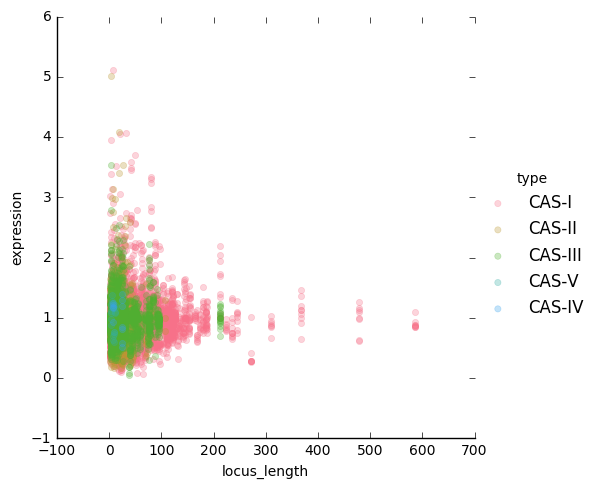

In [143]:
sns.lmplot(x = 'locus_length', y = 'expression', hue = 'type',
           data = expression_df.loc[~expression_df['type'].str.contains('partial')], 
           fit_reg = False, scatter_kws={'alpha':0.3})
plt.savefig("makarova_expression_all.png")

In [140]:
# spearman correlation for all makarova data
stats.spearmanr(expression_df['locus_length'], expression_df['expression'])

SpearmanrResult(correlation=-0.0011604173921244295, pvalue=0.91284881726190326)

In [144]:
#overall fit
stats.linregress(expression_df['locus_length'], 
                 expression_df['expression'])

LinregressResult(slope=-1.4416080494176872e-06, intercept=0.97354924179318192, rvalue=-0.00017790905631996258, pvalue=0.98661239395566092, stderr=8.5911588369581623e-05)

In [146]:
stats.spearmanr(expression_df.loc[expression_df['type'] == 'CAS-I']['locus_length'], 
                 expression_df.loc[expression_df['type'] == 'CAS-I']['expression'])

SpearmanrResult(correlation=-0.0024857510337163856, pvalue=0.84477941157834469)

In [147]:
stats.spearmanr(expression_df.loc[expression_df['type'] == 'CAS-II']['locus_length'], 
                 expression_df.loc[expression_df['type'] == 'CAS-II']['expression'])

SpearmanrResult(correlation=-0.05405257575981616, pvalue=0.18209456628593862)

In [148]:
stats.spearmanr(expression_df.loc[expression_df['type'] == 'CAS-III']['locus_length'], 
                 expression_df.loc[expression_df['type'] == 'CAS-III']['expression'])

SpearmanrResult(correlation=0.015006300599654384, pvalue=0.56470188504756147)

In [149]:
stats.spearmanr(expression_df.loc[expression_df['type'] == 'CAS-IV']['locus_length'], 
                 expression_df.loc[expression_df['type'] == 'CAS-IV']['expression'])

SpearmanrResult(correlation=-0.22034393241350797, pvalue=0.49135148460603872)

In [150]:
stats.spearmanr(expression_df.loc[expression_df['type'] == 'CAS-V']['locus_length'], 
                 expression_df.loc[expression_df['type'] == 'CAS-V']['expression'])

SpearmanrResult(correlation=-0.23873122764416504, pvalue=0.31075087377300026)

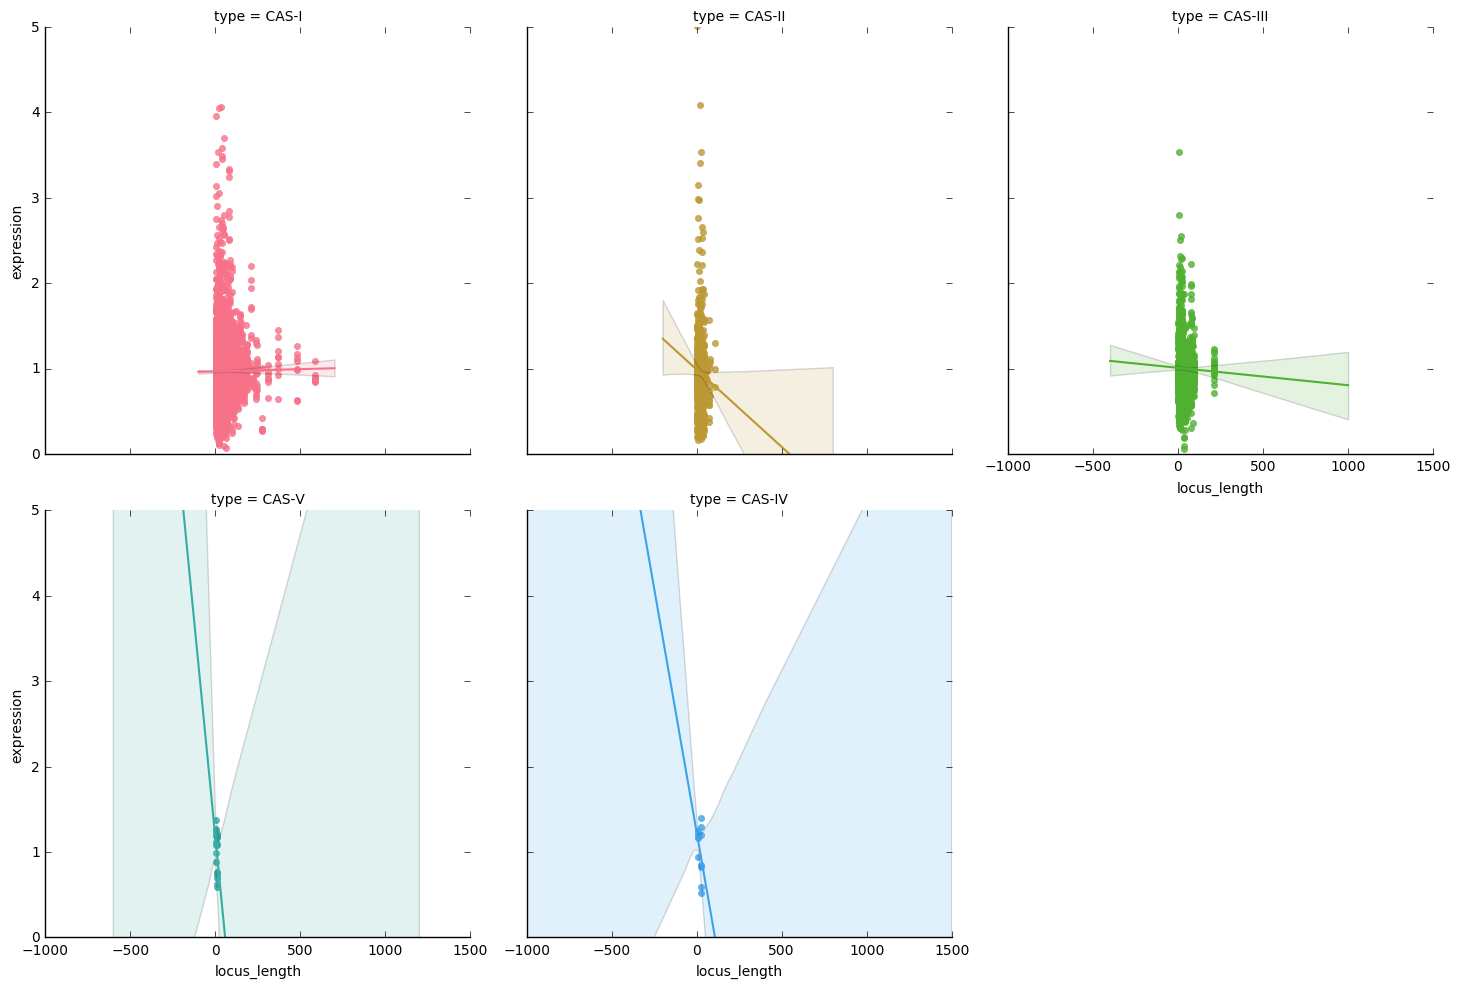

In [151]:
g = sns.lmplot(x = 'locus_length', y = 'expression', col = 'type', hue = 'type', col_wrap = 3,
           data = expression_df.loc[~expression_df['type'].str.contains('partial')], 
           fit_reg = True)
axes = g.axes
axes[0].set_ylim(0,5)
plt.savefig("makarova_expression_by_type.png")

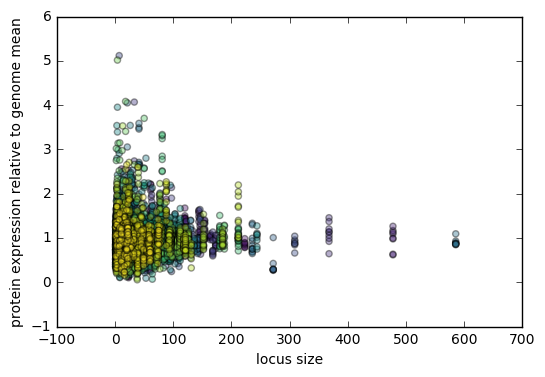

In [89]:
fig, ax = plt.subplots()
#ax.set_xscale('log')
ax.scatter(locus_size_list_flat, expression_list_flat, alpha = 0.4, c = locus_id_list_flat, cmap = "viridis")
#ax.plot(locus_size_list_flat, np.array(locus_size_list_flat)*A+B)
ax.set_xlabel("locus size")
ax.set_ylabel("protein expression relative to genome mean")
plt.savefig("makarova_cas_expression_vs_locus_size.png", dpi = 200)

## Normalize to some common genes

Instead of normalizing to the total expression for a cell, normalize to a set of 'housekeeping' or reference genes that most or all organisms should constitutively express. Genes involved in DNA replication are good candidates, since we would like things to be relative to cell generation times.

From some googling:

| Gene name | String to search in CDS annotation | Gene function | Approx length | Reference | Notes | 
| --------- | ---------------------------------- | ------------- | ------------- | --------- | ------ |
| recombinase A | recA                               | DNA repair, found in pretty much every organism | 353 aa | [PFAM](http://pfam.xfam.org/family/PF00154) | Homolog is radA in archaea |
|DNA gyrase A subunit| gyrA                             |      | | [BCCM](http://bccm.belspo.be/services/identification-using-sequence-analysis-housekeeping-genes-bccmlmg), |
|DNA gyrase B subunit| gyrB                            |      | | [BCCM](http://bccm.belspo.be/services/identification-using-sequence-analysis-housekeeping-genes-bccmlmg),   |
| chaperone DnaJ | dnaJ | | | [BCCM](http://bccm.belspo.be/services/identification-using-sequence-analysis-housekeeping-genes-bccmlmg), [PFAM](https://pfam.xfam.org/family/DnaJ) |
|  | rpoA | | | [BCCM](http://bccm.belspo.be/services/identification-using-sequence-analysis-housekeeping-genes-bccmlmg), |
|  | rpoB |  |  | [BCCM](http://bccm.belspo.be/services/identification-using-sequence-analysis-housekeeping-genes-bccmlmg),  |
|  | atpD | | | [BCCM](http://bccm.belspo.be/services/identification-using-sequence-analysis-housekeeping-genes-bccmlmg), |
|  | infB| | | [BCCM](http://bccm.belspo.be/services/identification-using-sequence-analysis-housekeeping-genes-bccmlmg), |
|  | gmk |  |  |  |
|  | 16S |  |  | | Not a gene, so maybe not the best choice? |


### Get gene names from fasta files and make a large data frame

In [90]:
from Bio import SeqIO

In [95]:
folder_python = '/media/madeleine/My Passport1/Data/AnaCoDa'

In [97]:
expression_all = pd.read_csv("all_expression_data.csv")

In [96]:
# DON'T RUN THIS unless it's the first time - takes a long time

expression_all = []
count = 0

for accession in tqdm(accessions_done['acc']):
    expression = pd.read_csv("%s/%s-expression.csv" %(folder, accession))
    # split names column from the right to isolate cds position
    names_split = expression["names"].str.rsplit("_", n=1, expand = True)  
    expression["protein_position"] = names_split.iloc[:,-1] # create column for cds position
    expression["protein_position"] = pd.to_numeric(expression["protein_position"]) # convert to numeric

    # make columns for gene and protein name
    expression["protein_name"] = np.nan
    expression["gene_name"] = np.nan

    org_id = accession_to_organism_id[accession]
    for record in SeqIO.parse("%s/%s.fasta" %(folder_python, accession), "fasta"):
        header = record.id

        cds_number = int(header.split('_')[-1])
        description = record.description

        try:
            protein = description[description.index("protein=") + 8:].split(']')[0]
            expression.loc[expression['protein_position'] == cds_number, 'protein_name'] = protein
            #print(protein)
        except:
            pass
        try:
            gene = description[description.index("gene=") + 5:].split(']')[0]
            expression.loc[expression['protein_position'] == cds_number, 'gene_name'] = gene
        except:
            pass
        
    # remove genes that have no protein or gene name
    expression = expression.loc[np.any(~pd.isnull(expression[['gene_name', 'protein_name']]), axis = 1)]

    expression['accession'] = accession # make accession column
    
    expression_all.append(expression) 
    count += 1
    
expression_all = pd.concat(expression_all)
            
# reset index and rename old index
expression_all = expression_all.reset_index()
expression_all = expression_all.rename({'index': 'old_index'})

expression_all[["index", "PHI", "Std.Error", "names", 
                "protein_position", "protein_name", 
                "gene_name", "accession" ]].to_csv("all_expression_data.csv")

100%|██████████| 1354/1354 [2:37:45<00:00,  4.82s/it]


In [160]:
# remove NAs for gene and protein name columns
expression_all_protein = expression_all.dropna(subset = ['protein_name'])
expression_all_gene = expression_all.dropna(subset = ['gene_name'])

In [337]:
def create_normalized_df(expression_all, gene_inds):
    """
    Create a dataframe with a new column 'expression_normalized' where expression values are normalized to a chosen gene.
    Inputs:
    expression_all : dataframe with all genes and expression levels for the organisms being considered
    gene_inds : list of indices that correspond to rows in `expression_all` that match the normalization gene of interest
    
    Outputs:
    expression_df_normalized : same structure as expression_all, 
        subsetted with the organisms that could be normalized and with an extra column `expression_normalized`
    spearman : spearman correlation of expression_normalized and locus_length
    casN_spearman : spearman correlation of expression_normalized and locus_length for particular CRISPR types
    """
    normalization_df = expression_all.loc[gene_inds] # dataframe of just the normalization genes
    
    # if more than one gene per organism, then take the mean so that each organism has a single normalization value
    normalization_means = normalization_df.groupby(['accession'])['PHI'].mean().reset_index()
    
    # these organisms have the normalization gene to normalize with
    expression_df_normalized = expression_df.loc[expression_df['accession'].isin(normalization_means['accession'])]
    
    # normalize all cas genes to the normalization value for each organism
    norm_list = []
    for index, row in expression_df_normalized.iterrows():
        accession = row['accession']
        norm_list.append(row['expression'] / float(normalization_means.loc[normalization_means['accession'] == accession]['PHI']))
    
    # assign to column
    expression_df_normalized['expression_normalized'] = norm_list
    
    # get spearman correlations
    spearman =  stats.spearmanr(expression_df_normalized['locus_length'], 
                                expression_df_normalized['expression_normalized'])
    casI_spearman = stats.spearmanr(expression_df_normalized.loc[expression_df_normalized['type'] == 
                                                                 'CAS-I']['locus_length'], 
                 expression_df_normalized.loc[expression_df_normalized['type'] == 
                                              'CAS-I']['expression_normalized'])
    casII_spearman = stats.spearmanr(expression_df_normalized.loc[expression_df_normalized['type'] == 
                                                                 'CAS-II']['locus_length'], 
                 expression_df_normalized.loc[expression_df_normalized['type'] == 
                                              'CAS-II']['expression_normalized'])
    casIII_spearman = stats.spearmanr(expression_df_normalized.loc[expression_df_normalized['type'] == 
                                                                 'CAS-III']['locus_length'], 
                 expression_df_normalized.loc[expression_df_normalized['type'] == 
                                              'CAS-III']['expression_normalized'])
    casIV_spearman = stats.spearmanr(expression_df_normalized.loc[expression_df_normalized['type'] == 
                                                                 'CAS-IV']['locus_length'], 
                 expression_df_normalized.loc[expression_df_normalized['type'] == 
                                              'CAS-IV']['expression_normalized'])
    casV_spearman = stats.spearmanr(expression_df_normalized.loc[expression_df_normalized['type'] == 
                                                                 'CAS-V']['locus_length'], 
                 expression_df_normalized.loc[expression_df_normalized['type'] == 
                                              'CAS-V']['expression_normalized'])
    
    return (expression_df_normalized, spearman, casI_spearman, casII_spearman, 
            casIII_spearman, casIV_spearman, casV_spearman)

#### Normalize to recA

In [404]:
# get row indices for genes that are recA
rec_A_gene_inds = expression_all_gene.loc[expression_all_gene['gene_name'].str.contains('recA', case=False)].index
rad_A_gene_inds = expression_all_gene.loc[expression_all_gene['gene_name'].str.contains('radA', case=False)].index

In [405]:
# get row indices for protein names that contain recA

rec_A_protein_inds1 = expression_all_protein.loc[expression_all_protein
                                                 ['protein_name'].str.contains('recA', case=False)].index
rec_A_protein_inds2 = expression_all_protein.loc[expression_all_protein
                                                 ['protein_name'].str.contains('recombinase', case=False)].index

In [406]:
# get indices for proteins that have both 'recombinase' and 'recA' in their name
protein_inds = set(rec_A_protein_inds1).intersection(set(rec_A_protein_inds2))

gene_protein_inds = np.sort(list(set(protein_inds).union(set(rec_A_gene_inds), set(rad_A_gene_inds))))

In [407]:
(expression_df_recA, spearman, casI_spearman, casII_spearman, 
            casIII_spearman, casIV_spearman, casV_spearman) = create_normalized_df(expression_all, gene_protein_inds)

/home/madeleine/anaconda2/envs/django/lib/python3.5/site-packages/ipykernel/__main__.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [408]:
print("Overall:", spearman, '\nCAS-I', casI_spearman, '\nCAS-II',casII_spearman, '\nCAS-III',
      casIII_spearman, '\nCAS-IV',casIV_spearman, '\nCAS-V',casV_spearman)

Overall: SpearmanrResult(correlation=0.13989078699827528, pvalue=6.087546288097776e-34) 
CAS-I SpearmanrResult(correlation=0.16159116469959708, pvalue=2.0380651584617873e-31) 
CAS-II SpearmanrResult(correlation=-0.057055491081952174, pvalue=0.16454746513774551) 
CAS-III SpearmanrResult(correlation=0.21794199212496482, pvalue=4.800173265264103e-15) 
CAS-IV SpearmanrResult(correlation=nan, pvalue=nan) 
CAS-V SpearmanrResult(correlation=-0.67667011566272284, pvalue=0.0039933770208588617)


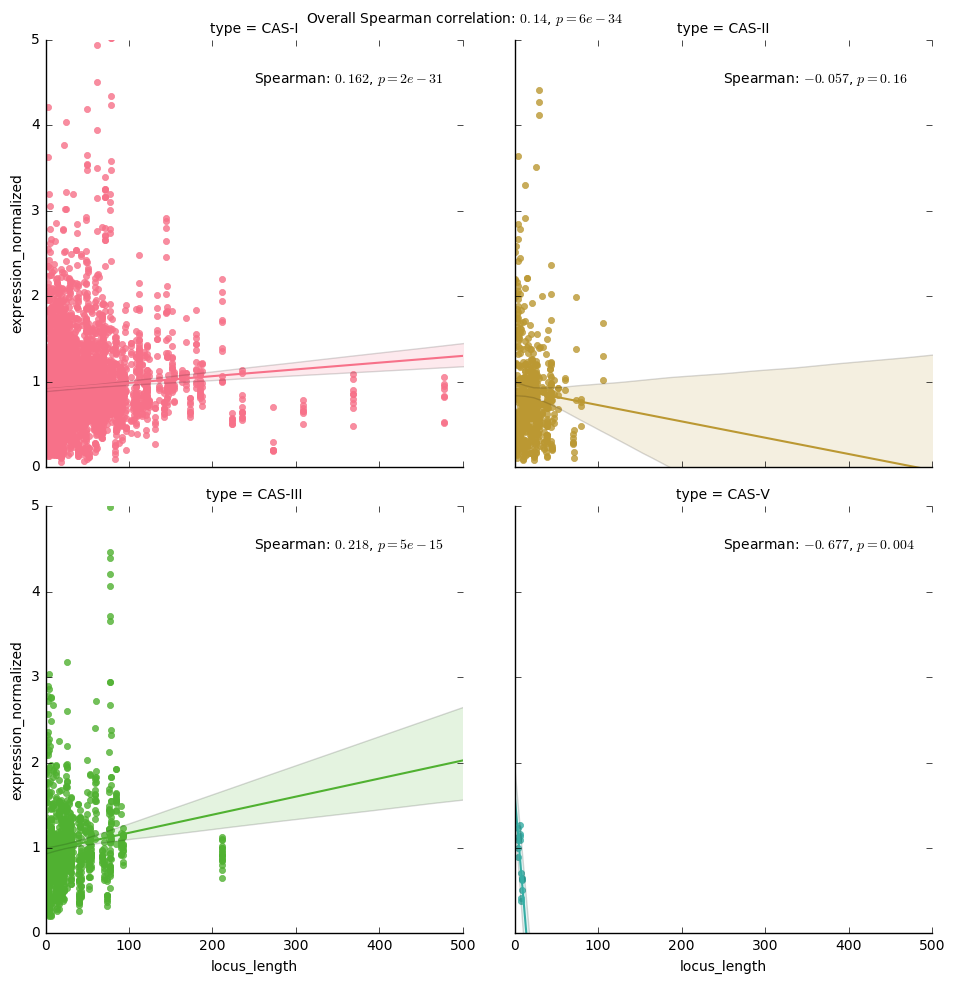

In [409]:
g = sns.lmplot(x = 'locus_length', y = 'expression_normalized', col = 'type', hue = 'type', col_wrap = 2,
           data = expression_df_recA.loc[~expression_df_recA['type'].str.contains('partial')], 
           fit_reg = True)
axes = g.axes
axes[0].annotate(r"Spearman: $%s$, $p=%s$" %(round(casI_spearman[0],3), round(casI_spearman[1],31)), 
                 xy = (0.5, 0.9), xycoords = 'axes fraction')
axes[1].annotate(r"Spearman: $%s$, $p=%s$" %(round(casII_spearman[0],3), round(casII_spearman[1],2)), 
                 xy = (0.5, 0.9), xycoords = 'axes fraction')
axes[2].annotate(r"Spearman: $%s$, $p=%s$" %(round(casIII_spearman[0],3), round(casIII_spearman[1],15)), 
                 xy = (0.5, 0.9), xycoords = 'axes fraction')
axes[3].annotate(r"Spearman: $%s$, $p=%s$" %(round(casV_spearman[0],3), round(casV_spearman[1],4)), 
                 xy = (0.5, 0.9), xycoords = 'axes fraction')
plt.subplots_adjust(top=0.95)
g.fig.suptitle("Overall Spearman correlation: $%s$, $p=%s$" %(round(spearman[0],3), round(spearman[1],34)))
axes[0].set_ylim(0,5)
axes[0].set_xlim(0,500)
plt.savefig("makarova_expression_by_type_recA.png")

#### Normalize to 16S

In [410]:
# get row indices for protein names that contain 16S
sixteen_S_protein_inds = expression_all_protein.loc[expression_all_protein
                                                  ['protein_name'].str.contains('16S', case=False)].index


In [411]:
gene_protein_inds = np.sort(list(sixteen_S_protein_inds))

In [412]:
(expression_df_16S, spearman, casI_spearman, casII_spearman, 
            casIII_spearman, casIV_spearman, casV_spearman) = create_normalized_df(expression_all, gene_protein_inds)

/home/madeleine/anaconda2/envs/django/lib/python3.5/site-packages/ipykernel/__main__.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [413]:
print("Overall:", spearman, '\nCAS-I', casI_spearman, '\nCAS-II',casII_spearman, '\nCAS-III',
      casIII_spearman, '\nCAS-IV',casIV_spearman, '\nCAS-V',casV_spearman)

Overall: SpearmanrResult(correlation=-0.0095420202377613506, pvalue=0.38970519050657337) 
CAS-I SpearmanrResult(correlation=-0.0074235025244696242, pvalue=0.57423848919483822) 
CAS-II SpearmanrResult(correlation=-0.12863507395536616, pvalue=0.0015210201199193703) 
CAS-III SpearmanrResult(correlation=0.05156704095106935, pvalue=0.061561979704485306) 
CAS-IV SpearmanrResult(correlation=nan, pvalue=nan) 
CAS-V SpearmanrResult(correlation=-0.49723848948698962, pvalue=0.050037629131943755)


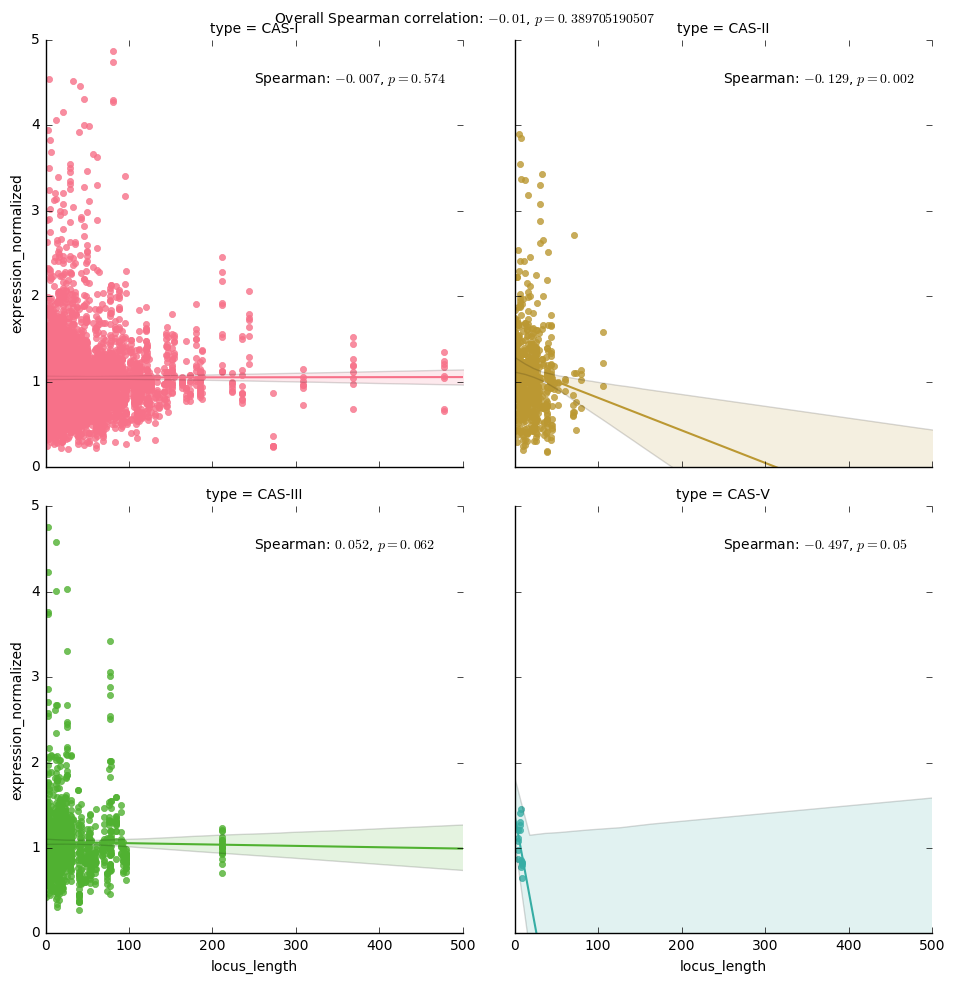

In [414]:
g = sns.lmplot(x = 'locus_length', y = 'expression_normalized', col = 'type', hue = 'type', col_wrap = 2,
           data = expression_df_16S.loc[~expression_df_16S['type'].str.contains('partial')], 
           fit_reg = True)
axes = g.axes
axes[0].annotate(r"Spearman: $%s$, $p=%s$" %(round(casI_spearman[0],3), round(casI_spearman[1],3)), 
                 xy = (0.5, 0.9), xycoords = 'axes fraction')
axes[1].annotate(r"Spearman: $%s$, $p=%s$" %(round(casII_spearman[0],3), round(casII_spearman[1],3)), 
                 xy = (0.5, 0.9), xycoords = 'axes fraction')
axes[2].annotate(r"Spearman: $%s$, $p=%s$" %(round(casIII_spearman[0],3), round(casIII_spearman[1],3)), 
                 xy = (0.5, 0.9), xycoords = 'axes fraction')
axes[3].annotate(r"Spearman: $%s$, $p=%s$" %(round(casV_spearman[0],3), round(casV_spearman[1],3)), 
                 xy = (0.5, 0.9), xycoords = 'axes fraction')
plt.subplots_adjust(top=0.95)
g.fig.suptitle("Overall Spearman correlation: $%s$, $p=%s$" %(round(spearman[0],3), round(spearman[1],34)))
axes[0].set_ylim(0,5)
axes[0].set_xlim(0,500)
plt.savefig("makarova_expression_by_type_16S.png")

#### Normalize to gyrA

In [372]:
# get row indices for genes that are recA
gyrA_gene_inds = expression_all_gene.loc[expression_all_gene['gene_name'].str.contains('gyrA', case=False)].index

In [378]:
# get row indices for protein names that contain recA

gyrA_protein_inds1 = expression_all_protein.loc[expression_all_protein
                                                 ['protein_name'].str.contains('DNA gyrase', case=False)].index
gyrA_protein_inds2 = expression_all_protein.loc[expression_all_protein
                                                 ['protein_name'].str.contains(' A', case=False)].index

In [379]:
# get indices for proteins that have both 'DNA gyrase' and ' A' in their name
protein_inds = set(gyrA_protein_inds1).intersection(set(gyrA_protein_inds2))

gene_protein_inds = np.sort(list(set(protein_inds).union(set(gyrA_gene_inds))))

In [382]:
(expression_df_gyrA, spearman, casI_spearman, casII_spearman, 
            casIII_spearman, casIV_spearman, casV_spearman) = create_normalized_df(expression_all, gene_protein_inds)

/home/madeleine/anaconda2/envs/django/lib/python3.5/site-packages/ipykernel/__main__.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/madeleine/anaconda2/envs/django/lib/python3.5/site-packages/numpy/lib/function_base.py:2569: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/madeleine/anaconda2/envs/django/lib/python3.5/site-packages/numpy/lib/function_base.py:2570: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/madeleine/anaconda2/envs/django/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/madeleine/anaconda2/envs/django/lib/python3.5/site-packages/scipy/stats/_di

In [383]:
print("Overall:", spearman, '\nCAS-I', casI_spearman, '\nCAS-II',casII_spearman, '\nCAS-III',
      casIII_spearman, '\nCAS-IV',casIV_spearman, '\nCAS-V',casV_spearman)

Overall: SpearmanrResult(correlation=0.15162399806337257, pvalue=2.3457182386290072e-34) 
CAS-I SpearmanrResult(correlation=0.15778369007564522, pvalue=8.3803843288293348e-26) 
CAS-II SpearmanrResult(correlation=-0.041196979714486617, pvalue=0.34614583023580103) 
CAS-III SpearmanrResult(correlation=0.21372731618178459, pvalue=3.2611166531220286e-13) 
CAS-IV SpearmanrResult(correlation=nan, pvalue=nan) 
CAS-V SpearmanrResult(correlation=-0.18576513533726027, pvalue=0.43296014321960385)


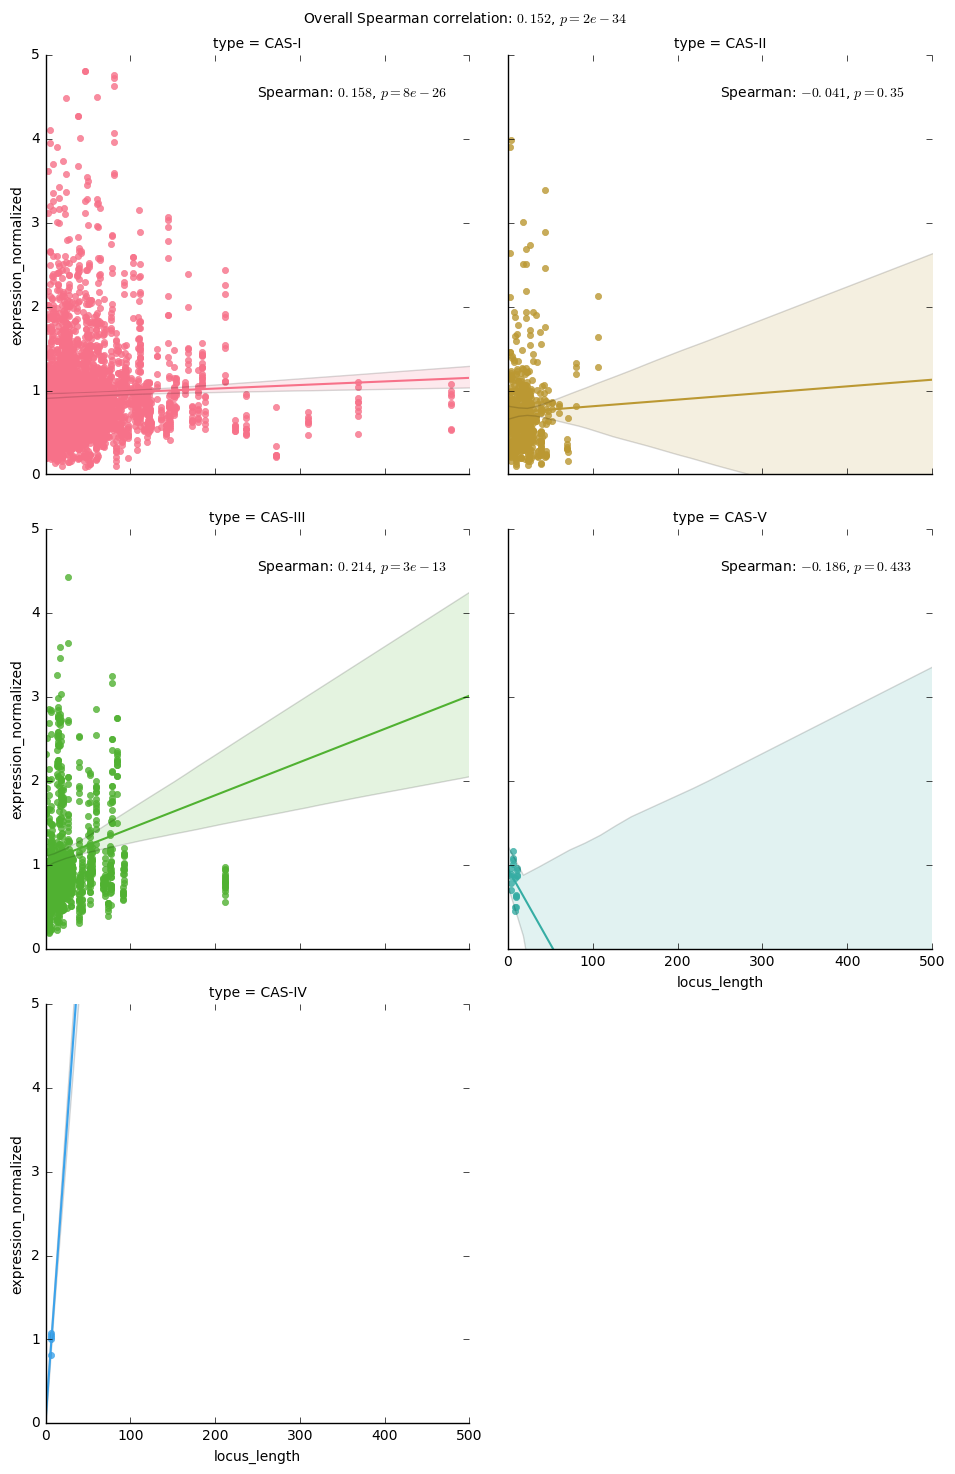

In [393]:
g = sns.lmplot(x = 'locus_length', y = 'expression_normalized', col = 'type', hue = 'type', col_wrap = 2,
           data = expression_df_gyrA.loc[~expression_df_gyrA['type'].str.contains('partial')], 
           fit_reg = True)
axes = g.axes
axes[0].annotate(r"Spearman: $%s$, $p=%s$" %(round(casI_spearman[0],3), round(casI_spearman[1],26)), 
                 xy = (0.5, 0.9), xycoords = 'axes fraction')
axes[1].annotate(r"Spearman: $%s$, $p=%s$" %(round(casII_spearman[0],3), round(casII_spearman[1],2)), 
                 xy = (0.5, 0.9), xycoords = 'axes fraction')
axes[2].annotate(r"Spearman: $%s$, $p=%s$" %(round(casIII_spearman[0],3), round(casIII_spearman[1],13)), 
                 xy = (0.5, 0.9), xycoords = 'axes fraction')
axes[3].annotate(r"Spearman: $%s$, $p=%s$" %(round(casV_spearman[0],3), round(casV_spearman[1],3)), 
                 xy = (0.5, 0.9), xycoords = 'axes fraction')
#axes[4].annotate(r"Spearman: $%s$, $p=%s$" %(round(casIV_spearman[0],3), round(casIV_spearman[1],3)), 
#                 xy = (0.5, 0.9), xycoords = 'axes fraction')
plt.subplots_adjust(top=0.95)
g.fig.suptitle("Overall Spearman correlation: $%s$, $p=%s$" %(round(spearman[0],3), round(spearman[1],34)))
axes[0].set_ylim(0,5)
axes[0].set_xlim(0,500)
plt.savefig("makarova_expression_by_type_gyrA.png")

#### Normalize to gyrB

In [394]:
# get row indices for genes that are recA
gyrB_gene_inds = expression_all_gene.loc[expression_all_gene['gene_name'].str.contains('gyrB', case=False)].index

In [396]:
# get row indices for protein names that contain recA

gyrB_protein_inds1 = expression_all_protein.loc[expression_all_protein
                                                 ['protein_name'].str.contains('DNA gyrase', case=False)].index
gyrB_protein_inds2 = expression_all_protein.loc[expression_all_protein
                                                 ['protein_name'].str.contains(' B', case=False)].index

In [397]:
# get indices for proteins that have both 'DNA gyrase' and ' A' in their name
protein_inds = set(gyrB_protein_inds1).intersection(set(gyrB_protein_inds2))

gene_protein_inds = np.sort(list(set(protein_inds).union(set(gyrB_gene_inds))))

In [398]:
(expression_df_gyrB, spearman, casI_spearman, casII_spearman, 
            casIII_spearman, casIV_spearman, casV_spearman) = create_normalized_df(expression_all, gene_protein_inds)

/home/madeleine/anaconda2/envs/django/lib/python3.5/site-packages/ipykernel/__main__.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/madeleine/anaconda2/envs/django/lib/python3.5/site-packages/numpy/lib/function_base.py:2569: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/madeleine/anaconda2/envs/django/lib/python3.5/site-packages/numpy/lib/function_base.py:2570: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/madeleine/anaconda2/envs/django/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/madeleine/anaconda2/envs/django/lib/python3.5/site-packages/scipy/stats/_di

In [399]:
print("Overall:", spearman, '\nCAS-I', casI_spearman, '\nCAS-II',casII_spearman, '\nCAS-III',
      casIII_spearman, '\nCAS-IV',casIV_spearman, '\nCAS-V',casV_spearman)

Overall: SpearmanrResult(correlation=0.17136629593615751, pvalue=9.0702109553831122e-23) 
CAS-I SpearmanrResult(correlation=0.2269792740994187, pvalue=8.2450672089599297e-30) 
CAS-II SpearmanrResult(correlation=-0.1518388408413778, pvalue=0.060130809027836851) 
CAS-III SpearmanrResult(correlation=0.077441802050297784, pvalue=0.082107402764126758) 
CAS-IV SpearmanrResult(correlation=nan, pvalue=nan) 
CAS-V SpearmanrResult(correlation=0.86602540378443882, pvalue=0.011724811003954599)


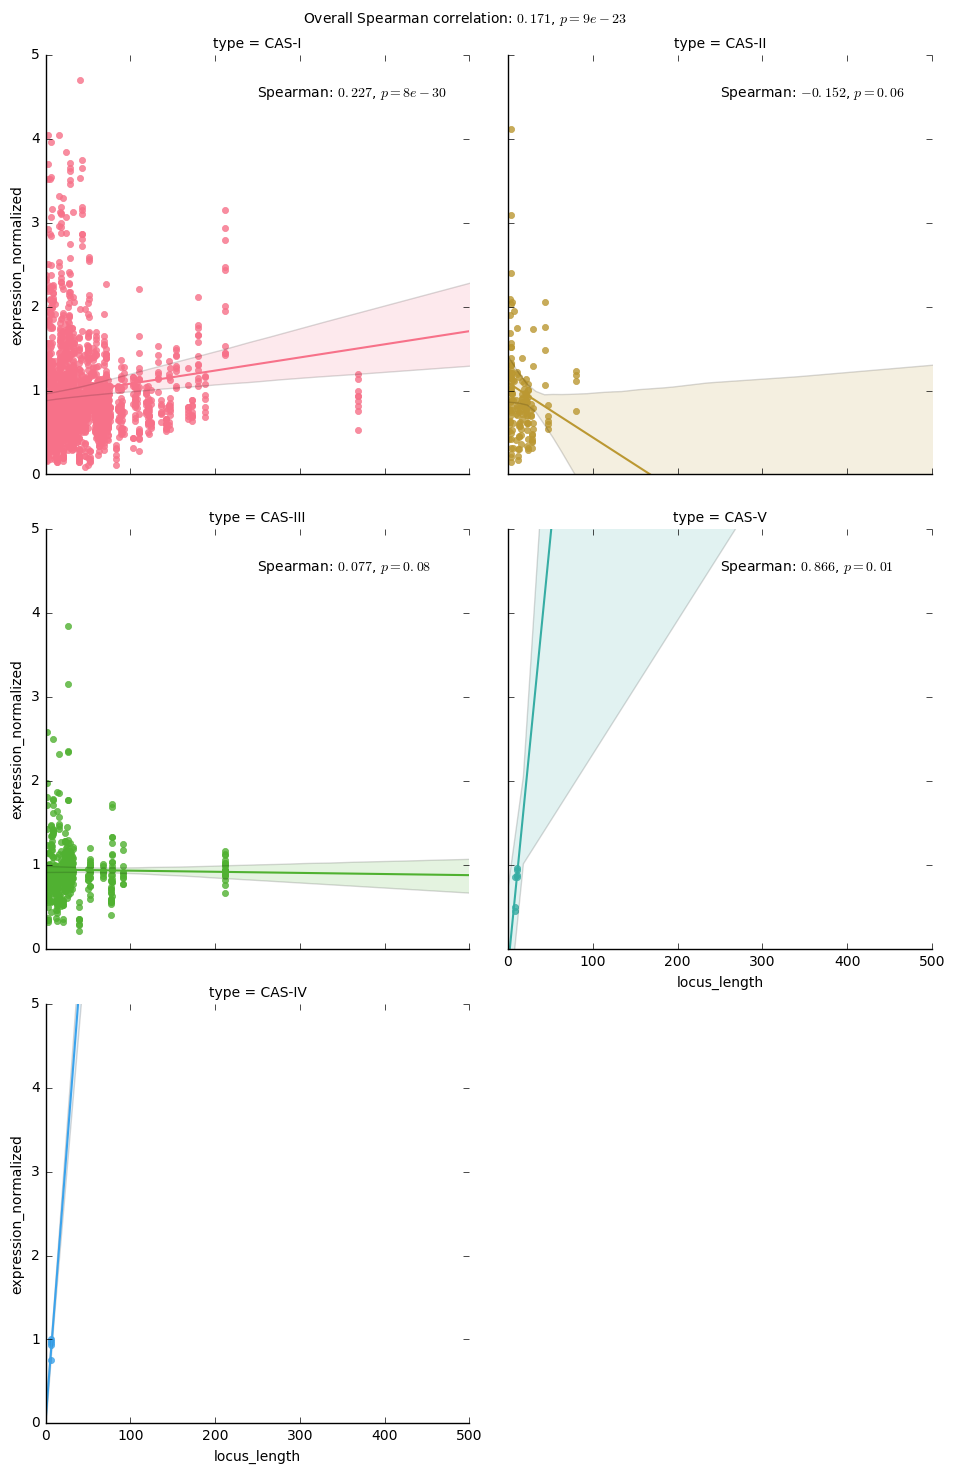

In [403]:
g = sns.lmplot(x = 'locus_length', y = 'expression_normalized', col = 'type', hue = 'type', col_wrap = 2,
           data = expression_df_gyrB.loc[~expression_df_gyrB['type'].str.contains('partial')], 
           fit_reg = True)
axes = g.axes
axes[0].annotate(r"Spearman: $%s$, $p=%s$" %(round(casI_spearman[0],3), round(casI_spearman[1],30)), 
                 xy = (0.5, 0.9), xycoords = 'axes fraction')
axes[1].annotate(r"Spearman: $%s$, $p=%s$" %(round(casII_spearman[0],3), round(casII_spearman[1],2)), 
                 xy = (0.5, 0.9), xycoords = 'axes fraction')
axes[2].annotate(r"Spearman: $%s$, $p=%s$" %(round(casIII_spearman[0],3), round(casIII_spearman[1],2)), 
                 xy = (0.5, 0.9), xycoords = 'axes fraction')
axes[3].annotate(r"Spearman: $%s$, $p=%s$" %(round(casV_spearman[0],3), round(casV_spearman[1],2)), 
                 xy = (0.5, 0.9), xycoords = 'axes fraction')
#axes[4].annotate(r"Spearman: $%s$, $p=%s$" %(round(casIV_spearman[0],3), round(casIV_spearman[1],3)), 
#                 xy = (0.5, 0.9), xycoords = 'axes fraction')
plt.subplots_adjust(top=0.95)
g.fig.suptitle("Overall Spearman correlation: $%s$, $p=%s$" %(round(spearman[0],3), round(spearman[1],23)))
axes[0].set_ylim(0,5)
axes[0].set_xlim(0,500)
plt.savefig("makarova_expression_by_type_gyrB.png")

## Compare local and scinet runs of AnaCoDa - make sure they're consistent

In [17]:
compare_accessions = ["NC_000853", "NC_000868", "NC_000909"]

(0.99965824371657874, 0.0)
(0.99971317458074027, 0.0)
(0.99875036443657517, 0.0)


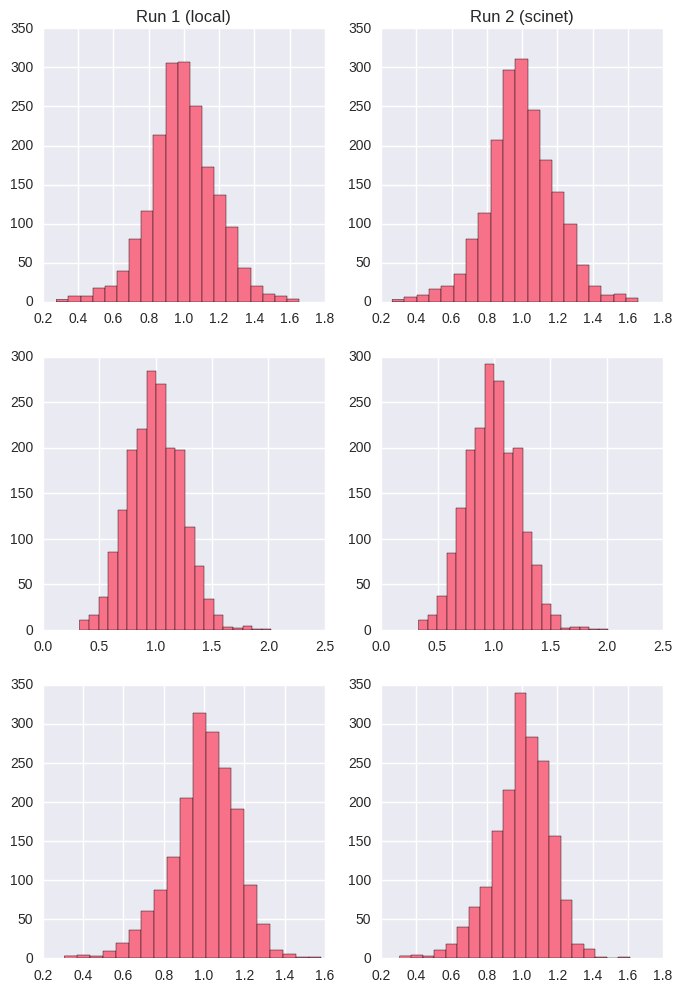

In [27]:
fig, ax = plt.subplots(3,2, figsize = (8,12))

for i, accession in enumerate(compare_accessions):
    expression_local = pd.read_csv("%s-expression_local.csv" %(accession))
    expression_scinet = pd.read_csv("%s-expression_scinet.csv" %accession)
    
    ax[i, 0].hist(expression_local.PHI, bins = 20)
    ax[i, 1].hist(expression_scinet.PHI, bins = 20)
    
    print(pearsonr(expression_local.PHI, expression_scinet.PHI))
    
ax[0,0].set_title("Run 1 (local)")
ax[0,1].set_title("Run 2 (scinet)")
    